In [1022]:
# !pip3 install yfinance
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
import missingno
import glob
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import euclidean_distances

In [764]:
locations = ['samut prakan', 'chulalongkorn-hospital', 'samut sakhon', 'thonburi-power']
prefix = './sub_stations/'
x = []
for location in locations:
    globals()[location] = pd.read_csv(prefix+location+'.csv')
    globals()[location]['location'] = location 
    x.append(globals()[location])
x=pd.concat(x)
energy = pd.read_csv('./per-capita-energy-use.csv')
sc_pr = pd.read_csv('./sc_pr.csv')

In [765]:
x.rename(columns={' pm25':'pm25', ' pm10':'pm10', ' o3':'o3',' no2':'no2', ' so2':'so2', ' co':'co'}, inplace=True)

sc_pr.rename(columns = {'w_0':'date', 'w_1':'price'}, inplace=True)
sc_pr.drop(columns = {'Unnamed: 0'}, inplace =True)

In [766]:
cols = ['pm25','pm10', 'o3', 'no2','so2','co']
x[cols]=x[cols].apply(lambda x: x.replace(' ', np.NAN), axis=1)
z[cols]=z[cols].apply(lambda x: x.replace(' ', np.NAN), axis=1)

In [767]:
sc_pr['date']=pd.to_datetime(sc_pr['date'])
sc_pr['year'] = sc_pr['date'].dt.year

In [768]:
x['pm25'] = x['pm25'].astype('float')
x['pm10'] = x['pm10'].astype('float')
x['co']=x['co'].astype('float')

In [769]:
x['date']=pd.to_datetime(x['date'])

In [770]:
x

,date,pm25,pm10,o3,no2,so2,co,location
0,2024-10-01,72.0,NaN,NaN,NaN,NaN,NaN,samut prakan
1,2024-10-02,65.0,NaN,NaN,NaN,NaN,NaN,samut prakan
2,2024-10-03,70.0,NaN,NaN,NaN,NaN,NaN,samut prakan
3,2024-10-04,70.0,NaN,NaN,NaN,NaN,NaN,samut prakan
4,2024-10-05,93.0,NaN,NaN,NaN,NaN,NaN,samut prakan
...,...,...,...,...,...,...,...,...
3745,2014-03-31,NaN,NaN,8,11,4,21.0,thonburi-power
3746,2015-03-15,NaN,NaN,NaN,19,NaN,NaN,thonburi-power
3747,2014-04-08,NaN,NaN,NaN,28,7,21.0,thonburi-power
3748,2014-04-16,NaN,NaN,NaN,18,1,14.0,thonburi-power


<Axes: >

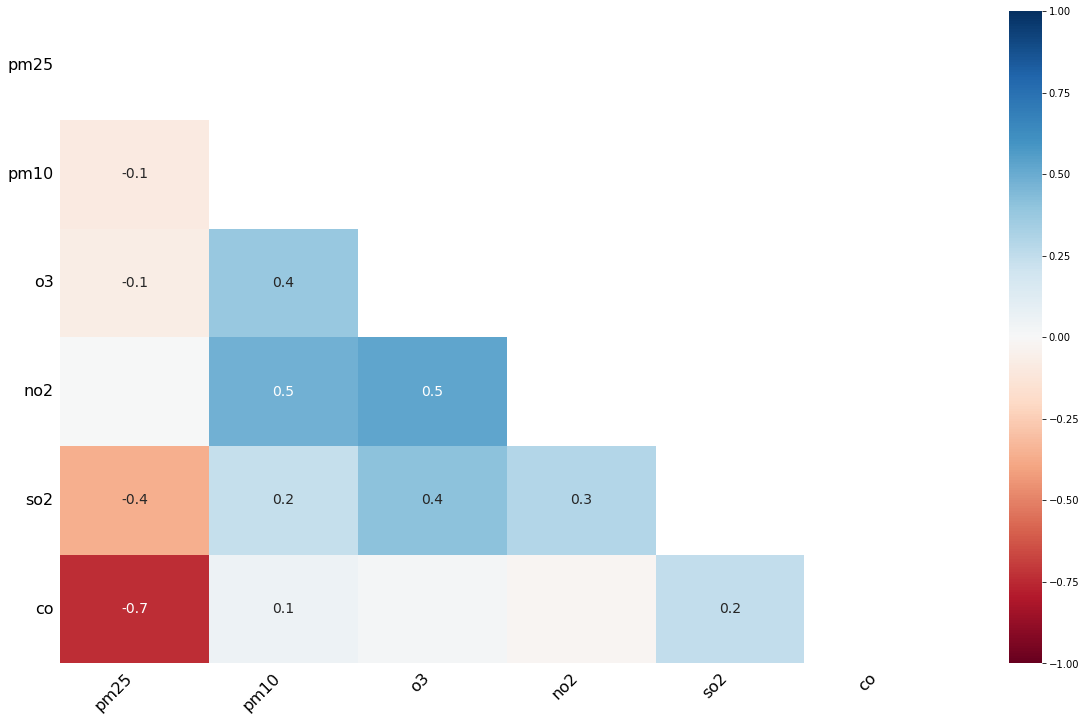

In [468]:
missingno.heatmap(x)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

Variables that are always full or always empty are not included in the visualization as they have no significant correlation.

The nullity correlation ranges from -1 to 1.

    -1 - Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
    0 - No correlation represents that variables values present or absent do not have any effect on one another.
    1 - Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present.

The heatmap works great for picking out data completeness relationships between variable pairs, but its explanatory power is limited when it comes to larger relationships and it has no particular support for extremely large datasets. For those, try the dendrogram instead.

**Further if you will read i will analyse more of those missing pattrens here we have just gist of it Let us try to explore more of missing value pattrens**

<Axes: >

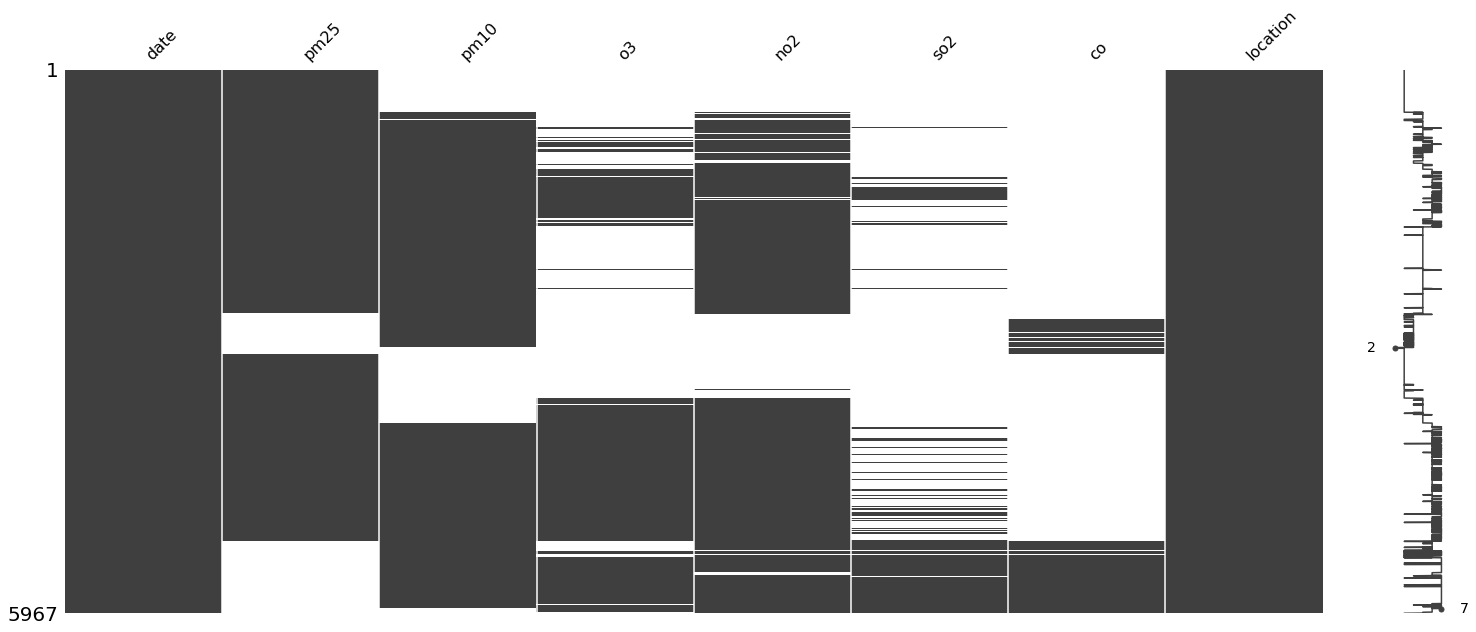

In [215]:
missingno.matrix(x)

In [499]:
# pd.read_excel('/home/qb/Downloads/T05_03_08.xls')

<span style="color:blue">Pointers:-</span>

* Here co level is mostly null, yet in the above correlation map shows the effect that it is -0.8 to -0.7 correlated with pm25 that means higher level of co will give lesser pm25 that is not true in reality and we cant trust this missness pattren. 
* Let look at other attributes no2 is forming very good rate with pm25 <span style="color:blue">we can try and fill in the average no2 level per pm25 for each location, similar goes with pm10 as it is more finite particals use both pm24 and p10 in order to fill in pm25</span>
* so2 and co2 in this reagion does not have much pattren we cant say how to fill it righ now for now lets merge the data and find more pattrens

In [745]:
#for co we add extra columns
x['co_features'] = x['co'].isna()*1

<Axes: xlabel='date', ylabel='pm25'>

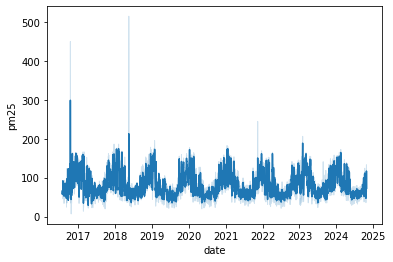

In [469]:
# x['month']=x['date'].dt.month
# x['year'] = x['date'].dt.year
x.set_index('date', inplace=True)
sns.lineplot(x['pm25'])

**Cyclic pattren accorss the cross-section**

In [771]:
x.reset_index(inplace=True)
x['month']=x['date'].dt.month
x['year'] = x['date'].dt.year
x['avg_pm25']=x.groupby(['location', 'month', 'year'])['pm25'].transform(lambda x: x.mean())
x.set_index(['year', 'month', 'location'], inplace=True) 
x=x[~x.index.duplicated(keep='first')]
x.reset_index(inplace=True)

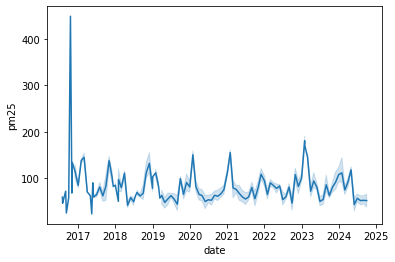

In [786]:
#x.reset_index(inplace =True)
x.set_index('date', inplace=True)
sns.lineplot(x['pm25'])
x.reset_index(inplace=True)

**Monthly data to merge and find pattren**

In [773]:
sc_pr['year'] = sc_pr['date'].dt.year
sc_pr['month'] = sc_pr['date'].dt.month
sc_pr.set_index(['year', 'month'], inplace=True)
x.set_index(['year', 'month'], inplace=True)
x['production']=sc_pr['price']
x.reset_index(inplace=True)

/tmp/ipykernel_19854/76678837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['production']=sc_pr['price']


**Pollution in such region is very cyclic monthly pattren**

<Axes: xlabel='year', ylabel='production'>

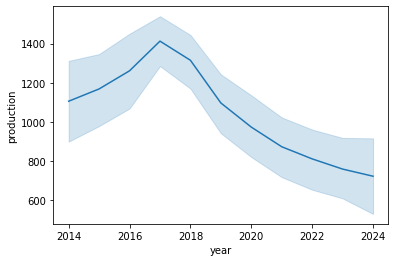

In [775]:
# x.set_index('date', inplace=True)
# x.reset_index(inplace=True)
x.set_index('year', inplace =True)
years = np.arange(2017, 2023)
sns.lineplot(np.sqrt(np.square(x['production'])).cumsum())

**Lets try to merge the industrial production with the, the above is yearly cyclic accross various stations industrial production**

/tmp/ipykernel_19854/3815311022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['transformed_production'] = np.sqrt(np.square(x['production'])).cumsum()
/tmp/ipykernel_19854/3815311022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[['production_scale', 'pm25_scale']]=scaler.fit_transform(x[['transformed_production', 'pm25']].values.reshape(-1, 2))


<Axes: xlabel='date', ylabel='production_scale'>

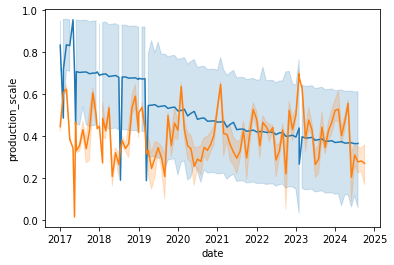

In [560]:
#please do not re-run this cell to get screenshot because the output might not be produced again
#scale the data down for effect accross time
scaler = MinMaxScaler()
x['transformed_production'] = np.sqrt(np.square(x['production'])).cumsum()
x[['production_scale', 'pm25_scale']]=scaler.fit_transform(x[['transformed_production', 'pm25']].values.reshape(-1, 2))
#sns.scatterplot(data= x.reset_index(), x='scale_production', y='pm25_scale', hue='location')
sns.lineplot(x['production_scale'][x['year'] >= 2017])
sns.lineplot((x['pm25_scale'][x['year']>=2017]))

**We can see average impact of industrial production and poultion rate, observe the accumulated impact**

/tmp/ipykernel_19854/2317864059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['transformed_production'] = np.sqrt(np.square(x['production'])).cumsum()


<Axes: xlabel='year'>

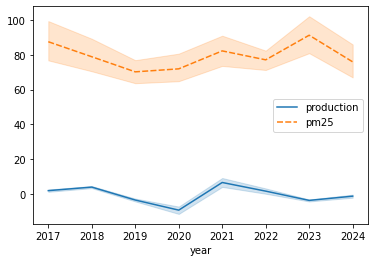

In [862]:
#scale the data down for effect accross time
# x.set_index('year', inplace=True)
# scaler = MinMaxScaler()
x['transformed_production'] = np.sqrt(np.square(x['production'])).cumsum()
# x[['production_scale', 'pm25_scale']]=scaler.fit_transform(x[['transformed_production', 'pm25']].values.reshape(-1, 2))
#sns.scatterplot(data= x.reset_index(), x='scale_production', y='pm25_scale', hue='location')
sns.lineplot(x[['production', 'pm25']][x.index >= 2017])
# sns.lineplot((x['pm25'][x.index >=2017]))

**We have accumulated affect at lag , here do some statsical test on this to varify the effect more**

<Axes: xlabel='year'>

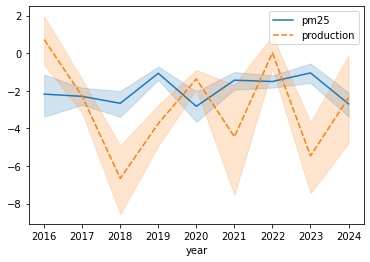

In [960]:
p=x[x['location'] == 'thonburi-power']['pm25']
idx=p[~p.isna()].index
r=x[x['location'] == 'thonburi-power'][['pm25','production']].loc[idx].pct_change().pct_change()
sns.lineplot(r)

In [1109]:
sc_pr=sc_pr.reset_index()
sc_pr.set_index('year', inplace=True)

In [1110]:
idx=[]
idx=np.arange(2017, 2024)
p=sc_pr.loc[idx]['price'].reset_index().set_index('year')

In [1134]:
k=x[x['location'] == 'thonburi-power']['pm25'].loc[idx].pct_change().backfill()

/tmp/ipykernel_19854/3545485946.py:1: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  k=x[x['location'] == 'samut sakhon']['pm25'].loc[idx].pct_change().backfill()


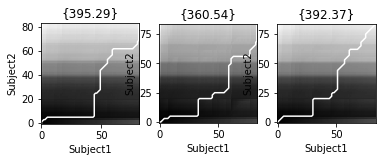

In [1162]:
from scipy.stats import norm
from dtw import dtw,accelerated_dtw

locations = ['chulalongkorn-hospital', 'samut sakhon', 'thonburi-power']


fig, ax = plt.subplots(1,3)
ax=ax.flatten()
for i,l in enumerate(locations):
    k=x[x['location'] == l]['pm25'].loc[idx].pct_change().bfill()
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(k.values,p.values , dist='euclidean')
    ax[i].imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    ax[i].plot(path[0], path[1], 'w')
    ax[i].set_xlabel('Subject1')
    ax[i].set_ylabel('Subject2')
    ax[i].set_title({np.round(d,2)})
    #ax[i].show()

**Here is the distance between  pm2.5 and industrial production, next we will perform vaious test and partial dependency plot in-order to check the behaviour shows the minumal distance**

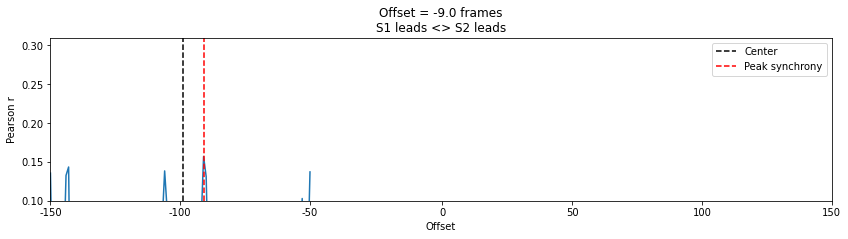

In [1135]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

seconds = 5
fps = 10
rs = [crosscorr(pd.Series(k.values.flatten()),pd.Series(p.values.flatten()), lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

In [1095]:
#to find the co-ordinates of location


0     0.333333
1     0.333333
2    -0.258333
3    -0.337079
4     0.322034
        ...   
77    0.181818
78   -0.131868
79    0.240506
80    0.744898
81   -0.152047
Length: 82, dtype: float64

<Axes: xlabel='year', ylabel='pm25'>

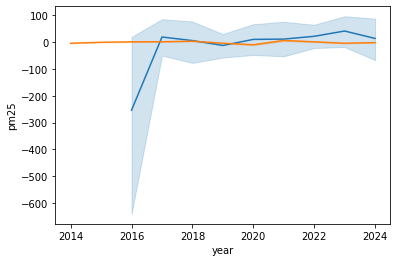

In [848]:
# t.set_index('year', inplace = True)
sns.lineplot(t['pm25'])
sns.lineplot(x['production'])

In [855]:
t

,month,level_2,pm25
year,,,
2014,1,96,NaN
2014,1,206,NaN
2014,1,451,NaN
2014,2,97,NaN
2014,2,207,NaN
...,...,...,...
2024,9,329,-55.677644
2024,10,0,NaN
2024,10,100,-72.380937


In [643]:
x=pd.merge(x, t, on=['year', 'location'], how='left')
# x.set_index('date', inplace =True)
# sns.lineplot(x[x['year'] == 2018]['t'])
# sns.lineplot(x[x['month'] == 2018]['production'])

KeyError: "None of ['date'] are in the columns"

In [651]:
# x.set_index('date', inplace=True)
# sns.lineplot(np.sqrt(np.square(x['production'])).cumsum())


0            NaN
1      -0.156849
2      -0.243883
3       0.000000
4       2.173807
          ...   
5119         NaN
5120         NaN
5121         NaN
5122         NaN
5123         NaN
Name: pm25_y, Length: 5124, dtype: float64

In [509]:
year=np.arange(x['year'], 2023)
month=np.arange(1,13)
plt.figure(figsize=(15,8))
idx = []
for y in year:
    for m in month:
        idx.append(str(m)+'_'+str(y))
g=sns.lineplot(sc_pr.loc[idx]['w_1'])
c=plt.xticks(rotation=90)


,year,month,location,pm25,pm10,o3,no2,so2,co,avg_pm25,production,scale_production,co_features
date,,,,,,,,,,,,,
2024-10-01,2024,10,samut prakan,4.276666,NaN,NaN,NaN,NaN,NaN,88.653846,NaN,NaN,1
2024-07-01,2024,7,samut prakan,4.248495,NaN,NaN,NaN,NaN,NaN,70.290323,1.63,NaN,1
2024-08-01,2024,8,samut prakan,4.204693,NaN,NaN,NaN,NaN,NaN,68.903226,-1.91,NaN,1
2024-09-01,2024,9,samut prakan,4.204693,NaN,NaN,NaN,NaN,NaN,77.666667,NaN,1.63,1
2024-04-01,2024,4,samut prakan,4.595120,NaN,NaN,NaN,NaN,NaN,96.466667,3.43,1.91,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-01,2014,5,thonburi-power,NaN,15.0,32,20,4,13.0,NaN,-5.41,1.71,0
2014-06-01,2014,6,thonburi-power,NaN,10.0,40,16,1,2.0,NaN,-5.02,3.86,0
2014-02-23,2014,2,thonburi-power,NaN,58.0,19,32,1,10.0,NaN,-3.80,5.41,0


In [476]:
# x=x[~(x['year'] == 2024)]
x

,year,month,location,date,pm25,pm10,o3,no2,so2,co,avg_pm25,production
0,2024,10,samut prakan,2024-10-01,72.0,NaN,NaN,NaN,NaN,NaN,88.653846,NaN
1,2024,7,samut prakan,2024-07-01,70.0,NaN,NaN,NaN,NaN,NaN,70.290323,1.63
2,2024,8,samut prakan,2024-08-01,67.0,NaN,NaN,NaN,NaN,NaN,68.903226,-1.91
3,2024,9,samut prakan,2024-09-01,67.0,NaN,NaN,NaN,NaN,NaN,77.666667,NaN
4,2024,4,samut prakan,2024-04-01,99.0,NaN,NaN,NaN,NaN,NaN,96.466667,3.43
...,...,...,...,...,...,...,...,...,...,...,...,...
447,2014,5,thonburi-power,2014-05-01,NaN,15.0,32,20,4,13.0,NaN,-5.41
448,2014,6,thonburi-power,2014-06-01,NaN,10.0,40,16,1,2.0,NaN,-5.02
449,2014,2,thonburi-power,2014-02-23,NaN,58.0,19,32,1,10.0,NaN,-3.80
450,2014,3,thonburi-power,2014-03-01,NaN,52.0,21,18,2,7.0,NaN,-6.85


<Axes: xlabel='date'>

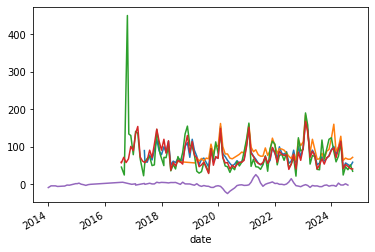

In [483]:
# x[x['location'] == 'chulalongkorn-hospital']['pm25'].astype('float').reset_index()['pm25'].plot()
# x.set_index('date', inplace =True)
# plt.scatter(np.sqrt(np.square(x['price'])), x['pm25'])
x[x['location'] == 'chulalongkorn-hospital']['pm25'].plot()
x[x['location'] == 'samut prakan']['pm25'].plot()
x[x['location'] == 'samut sakhon']['pm25'].plot()
x[x['location'] == 'thonburi-power']['pm25'].plot()

x[x['location'] == 'chulalongkorn-hospital']['production'].plot()

<Axes: xlabel='Year'>

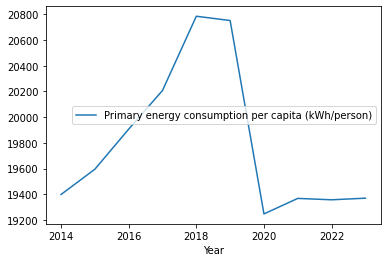

In [332]:
# energy =energy[energy['Entity'] == 'Thailand']
# energy.set_index('Year', inplace =True)
energy.loc[x['year'].min():x['year'].max()].plot()

In [497]:
# x['pm25'].hist()
x['scale_production'] = np.sqrt(np.square(x['production'])).shift(2)
# x['pm25']=np.log(x['pm25'])

/tmp/ipykernel_19854/1599195744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['scale_production'] = np.sqrt(np.square(x['production'])).shift(2)


In [491]:
x

,year,month,location,pm25,pm10,o3,no2,so2,co,avg_pm25,production,scale_profductiion,scale_production
date,,,,,,,,,,,,,
2024-10-01,2024,10,samut prakan,72.0,NaN,NaN,NaN,NaN,NaN,88.653846,NaN,NaN,NaN
2024-07-01,2024,7,samut prakan,70.0,NaN,NaN,NaN,NaN,NaN,70.290323,1.63,NaN,NaN
2024-08-01,2024,8,samut prakan,67.0,NaN,NaN,NaN,NaN,NaN,68.903226,-1.91,NaN,NaN
2024-09-01,2024,9,samut prakan,67.0,NaN,NaN,NaN,NaN,NaN,77.666667,NaN,1.63,1.63
2024-04-01,2024,4,samut prakan,99.0,NaN,NaN,NaN,NaN,NaN,96.466667,3.43,1.91,1.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-01,2014,5,thonburi-power,NaN,15.0,32,20,4,13.0,NaN,-5.41,1.71,1.71
2014-06-01,2014,6,thonburi-power,NaN,10.0,40,16,1,2.0,NaN,-5.02,3.86,3.86
2014-02-23,2014,2,thonburi-power,NaN,58.0,19,32,1,10.0,NaN,-3.80,5.41,5.41


<Axes: xlabel='scale_production', ylabel='pm25'>

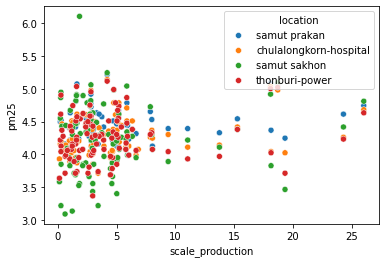

In [498]:
sns.scatterplot(data=x.reset_index() , x='scale_production', y='pm25', hue='location')

**Let us try to explore more stock market information**

In [ ]:
BPP = yf.Ticker("BPP.BK")
BPP.info
hist = BPP.history(period="5y")

In [59]:
x['price'] = sc_pr['price']

In [73]:
x=x[~x['price'].isna()]

<Axes: xlabel='date'>

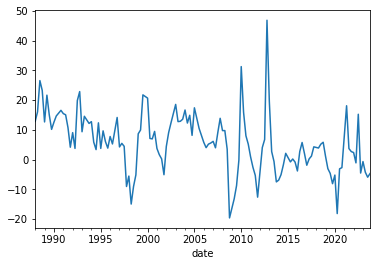

In [98]:
# x['price'].plot()
sc_pr['price'].plot()

In [101]:
#it is quaterly but why 4

date
2023Q4   -4.66
2023Q4   -4.66
2023Q4   -4.66
2023Q3   -5.88
2023Q3   -5.88
          ... 
2014Q1   -6.85
2014Q1   -6.85
2017Q1   -1.85
2017Q1   -1.85
2014Q4    2.15
Freq: Q-DEC, Name: price, Length: 92, dtype: float64

In [108]:
x.loc['2014Q1']

,level_0,index,year,month,date,pm25,pm10,o3,no2,so2,co,price
date,,,,,,,,,,,,
2014Q1,106,106,2014,1,2014-01-02,NaN,84,NaN,NaN,NaN,56,-6.85
2014Q1,107,107,2014,2,2014-02-07,NaN,63,NaN,NaN,NaN,35,-6.85


In [112]:
sc_pr['month']

date
1988Q1     1
1988Q2     4
1988Q3     8
1988Q4    11
1989Q1     2
          ..
2022Q4    11
2023Q1     2
2023Q2     6
2023Q3     9
2023Q4    12
Freq: Q-DEC, Name: month, Length: 133, dtype: int32

In [88]:
x['pm25']=x['pm25'].astype(dtype='float')

/tmp/ipykernel_8193/3987984777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pm25']=x['pm25'].astype(dtype='float')


In [61]:
BPP = yf.Ticker("BPP.BK")
BPP.info
hist = BPP.history(period="5y")

In [62]:
price=hist['Close']
price=price.reset_index()

In [63]:
# price.reset_index(inplace=True)
price['Date']=pd.to_datetime(price['Date'])
price['Date']=price['Date'].dt.normalize()
price['Date'] = price['Date'].dt.date

In [89]:
# x['date']=pd.to_datetime(x['date'])
x.rename(columns = {'date':'Date'}, inplace=True)

In [66]:
x.set_index('Date', inplace=True)
price.set_index('Date', inplace =True)
x['price'] = price['Close']
price.reset_index(inplace=True)
x.reset_index(inplace=True)

In [73]:
s_d=price.min()['Date']
f_d=price.max()['Date']

In [113]:
#x[' pm25']=x[' pm25'].replace(' ', np.NAN)
x[' pm25']=x[' pm25'].astype('float')

In [152]:
# x['week'] = x['Date'].dt
# x['year'] = x['Date'].dt.year
x['monthly_price']=x.groupby(['year', 'month'])['price'].transform(lambda x: x.mean())

In [136]:
x['wom'] = x['Date'].apply(lambda d: (d.day-1) // 7 + 1)

<Axes: >

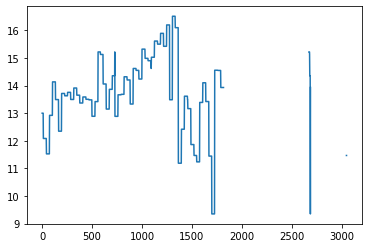

In [159]:
x['monthly_price'].plot()

<Axes: >

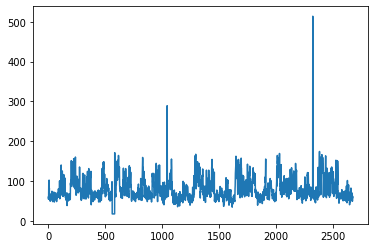

In [160]:
x[' pm25'].plot()

In [163]:
ow=pd.read_csv('./owid-co2-data.csv')

In [170]:
ow[ow['country'] == 'Thailand'].columns

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_chang

In [178]:
cols = ['year','consumption_co2', 'methane_per_capita', 'primary_energy_consumption', 'nitrous_oxide', 'other_industry_co2']

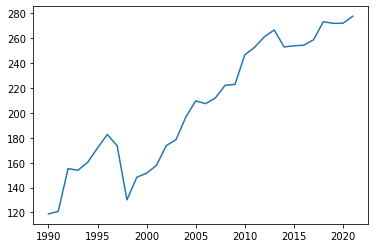

In [182]:
sample=ow[ow['country'] == 'Thailand'][cols]
plt.plot(sample['year'],sample['consumption_co2'])

<Axes: xlabel='year'>

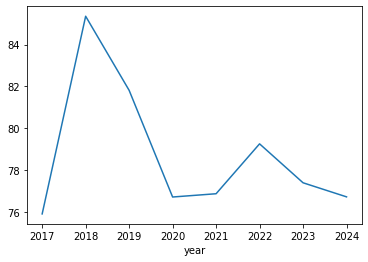

In [191]:
x.groupby('year')[' pm25'].apply(lambda x: x.mean()).plot()
